In [1]:
import pandas as pd 
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import FloatType
from cassandra.cluster import Cluster
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
caminho = "gs://arquivos_parquet_bucket/arquivos_parquet/"

# conexao com o cassandra
clstr = Cluster(['34.151.235.109'], port=9042)
session = clstr.connect('projeto_final')

# inicia sessão do spark
spark = SparkSession.builder.appName("projeto_final").config("spark.sql.caseSensitive", "True").config("spark.sql.debug.maxToStringFields",100).getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
dados = session.execute("select * from geracaoDistribuida;")
df_geracaoDistribuida = pd.DataFrame(dados)
#df_geracaoDistribuida.head()

In [4]:
df_gd1 = df_geracaoDistribuida.groupby(["anoreferencia","siggeracaodistribuida"]).sum()
df_gd = df_geracaoDistribuida.groupby("anoreferencia").sum()
df_gd.reset_index(inplace=True)
#df_gd.head()

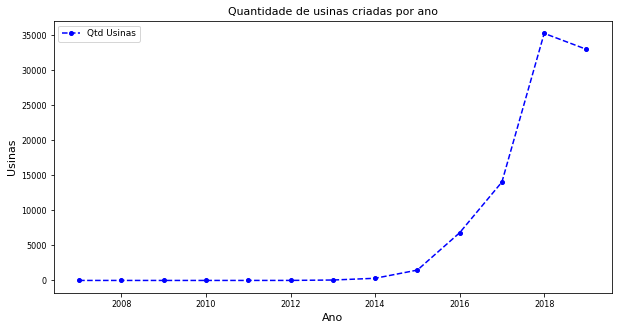

In [5]:
plt.figure(figsize=(10,5))
plt.plot(df_gd["anoreferencia"], df_gd["qtdusina"], linestyle='--', marker='o', color = 'blue', markersize = 4)
plt.title("Quantidade de usinas criadas por ano", fontsize=11)
plt.xlabel("Ano", fontsize=11)
plt.ylabel("Usinas", fontsize=11)
plt.legend(['Qtd Usinas'], fontsize=9)
plt.xticks(fontsize= 8)
plt.yticks(fontsize= 8)
plt.show()

In [6]:
df_gd1 = df_geracaoDistribuida.groupby(["anoreferencia","siggeracaodistribuida"]).sum()
df_gd1.query("anoreferencia >= 2013", inplace = True)
df_gd1.drop(columns=["idegeracaodistribuida",'mdapotenciainstaladakw','mesreferencia'], inplace = True)
df_gd1.reset_index(inplace=True)
df_gd1.head(50)

,anoreferencia,siggeracaodistribuida,qtdusina
0,2013,CGH,0
1,2013,EOL,7
2,2013,UFV,53
3,2013,UTE,0
4,2014,CGH,1
5,2014,EOL,10
6,2014,UFV,295
7,2014,UTE,2
8,2015,CGH,1
9,2015,EOL,21


In [7]:
eolica = df_gd1.loc[df_gd1["siggeracaodistribuida"] == 'EOL']
fotovoltaica = df_gd1.loc[df_gd1["siggeracaodistribuida"] == 'UFV']
termoeletrica = df_gd1.loc[df_gd1["siggeracaodistribuida"] == 'UTE']
hidroeletrica = df_gd1.loc[df_gd1["siggeracaodistribuida"] == 'CGH'] 

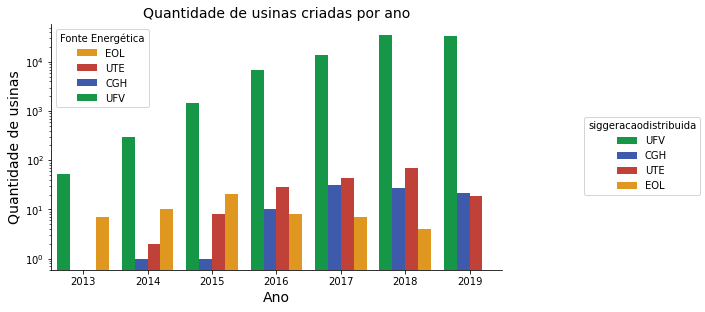

In [8]:
snsplt = sns.catplot( x="anoreferencia", y="qtdusina", kind="bar", data=df_gd1, legend=True, hue="siggeracaodistribuida",hue_order=['UFV','CGH','UTE','EOL'],palette=["#00ad43", "#2a52be", "#d62d20","#ff9f00"])
#plt.ylim(0,100)
plt.yscale("log")
plt.xlabel("Ano", fontsize=14)
plt.ylabel("Quantidade de usinas", fontsize=14)
plt.title("Quantidade de usinas criadas por ano", fontsize=14)
snsplt.fig.set_size_inches(11,4)
leg = snsplt._legend
leg.set_frame_on(True)
order = [3,2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper left", title="Fonte Energética")

In [9]:
termoeletrica.head(10)

,anoreferencia,siggeracaodistribuida,qtdusina
3,2013,UTE,0
7,2014,UTE,2
11,2015,UTE,8
15,2016,UTE,29
19,2017,UTE,43
23,2018,UTE,68
27,2019,UTE,19


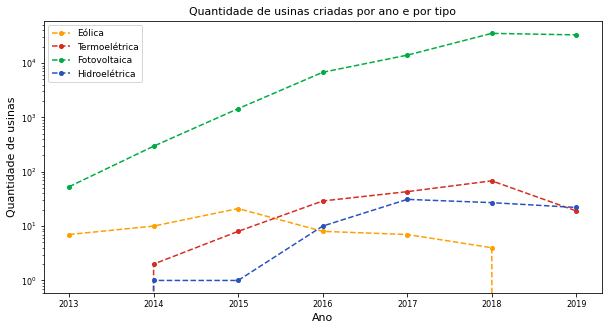

In [10]:
plt.figure(figsize=(10,5))
plt.yscale("log")
plt.plot(eolica["anoreferencia"], eolica["qtdusina"], linestyle='--', marker='o', color = "#ff9f00", markersize = 4)
plt.plot(termoeletrica["anoreferencia"], termoeletrica["qtdusina"], linestyle='--', marker='o', color = "#d62d20", markersize = 4)
plt.plot(fotovoltaica["anoreferencia"], fotovoltaica["qtdusina"], linestyle='--', marker='o', color = '#00ad43', markersize = 4)
plt.plot(hidroeletrica["anoreferencia"], hidroeletrica["qtdusina"], linestyle='--', marker='o', color = "#2a52be", markersize = 4)
plt.title("Quantidade de usinas criadas por ano e por tipo", fontsize=11)
plt.xlabel("Ano", fontsize=11)
plt.ylabel("Quantidade de usinas", fontsize=11)
plt.legend(['Eólica','Termoelétrica','Fotovoltaica','Hidroelétrica'], fontsize=9)
plt.xticks(fontsize= 8)
plt.yticks(fontsize= 8)
plt.show()


In [11]:
empreendimentos_gd = spark.read.parquet(caminho + "empreendimentos_gd")
tarifa_residencial = spark.read.parquet(caminho + "tarifamediaresidencial")

In [12]:
empreendimentos_gd.show()

+---+--------------------+-------------------+------+--------+-------+--------------------+---+-----------+---+---+----+---+------+-------+-------+--------------+--------+---+--------------+--------------------+-----------------+-------------------+---+--------------------+---+---+--------------+------------+-----+------+------+
|  0|                   1|                  2|     3|       4|      5|                   6|  7|          8|  9| 10|  11| 12|    13|     14|     15|            16|      17| 18|            19|                  20|               21|                 22| 23|                  24| 25| 26|            27|          28|   29|    30|    31|
+---+--------------------+-------------------+------+--------+-------+--------------------+---+-----------+---+---+----+---+------+-------+-------+--------------+--------+---+--------------+--------------------+-----------------+-------------------+---+--------------------+---+---+--------------+------------+-----+------+------+
|  1|Ge

In [13]:
tarifa_residencial_select = tarifa_residencial.select(tarifa_residencial['3'],tarifa_residencial['6'])
tarifa_residencial_agrupado = tarifa_residencial_select.groupBy('3').mean()
tarifa_residencial_agrupado.show()
#media de tarifa residencial por regiao

+---+------------------+
|  3|            avg(6)|
+---+------------------+
| NE|0.5766508333333333|
| S |0.5450737999999999|
| SE|0.6110436666666668|
| N |0.6159728571428571|
| CO|0.5727140000000001|
+---+------------------+



In [14]:
tarifa_residencial_select = tarifa_residencial.select(tarifa_residencial['2'],tarifa_residencial['6'])
tarifa_residencial_select.show()

+--------------------+-------+
|                   2|      6|
+--------------------+-------+
|               Chesp|0.57639|
|               Cocel|0.55712|
|             CODESAM|0.38685|
|              Coelba|0.55213|
|             Coopera|0.38709|
|       Cooperaliança| 0.4676|
|         Coopercocal| 0.4682|
|           Cooperluz|0.50384|
|          Coopermila|0.50633|
|         COOPERNORTE|0.67883|
|           COOPERSUL| 0.5476|
|           COOPERZEM| 0.5599|
|             Coorsel|0.59226|
|           Copel-DIS|0.51761|
|              Coprel|0.57118|
|              Cosern|0.50553|
|       CPFL Paulista|0.52302|
|    CPFL Piratininga|0.49018|
|CPFL Santa Cruz (...|0.54769|
|            Creluz-D|0.59232|
+--------------------+-------+
only showing top 20 rows



In [15]:
empreendimentos_filtrado = empreendimentos_gd.filter(empreendimentos_gd[8] == 'Residencial')
empreendimentos_select = empreendimentos_filtrado.select(empreendimentos_filtrado['5'],empreendimentos_filtrado['29'])
empreendimentos_agrupado = empreendimentos_select.groupBy('5').sum()
empreendimentos_agrupado.show()

+-------------------+------------------+
|                  5|           sum(29)|
+-------------------+------------------+
|            CEMIG-D|435889.09000000067|
|             CERAÇÁ|343.80999999999995|
|             CELG-D|164602.76000000004|
|                RGE|           6607.83|
|              CERON| 46989.71999999998|
|             CERTEL| 5147.690000000003|
|                AME|20940.700000000037|
|             EDP ES|43459.209999999934|
|    CPFL Santa Cruz|147.10999999999996|
|         MUXENERGIA|            709.23|
|              DCELT|2210.7299999999996|
|              CERCI| 649.3300000000003|
|CPFL Leste Paulista|             30.13|
|            CERILUZ|            132.93|
|             COELBA|128479.65999999939|
|              DEMEI|2610.0099999999998|
|             CERVAM| 78.74000000000001|
|           CERMOFUL|            325.02|
|                EMS| 89172.19999999942|
|              CERAL| 93.47999999999999|
+-------------------+------------------+
only showing top

In [16]:
#cria dataframe
lista = []
for linha in tarifa_residencial_select.collect():
    for linha1 in empreendimentos_agrupado.collect():
        if linha[0].upper() == linha1[0].upper():
            aux = (linha1[0],linha1[1],linha[1])
            lista.append(aux)
            
df = pd.DataFrame(lista,columns = ["SigAgente", "PotenciaInstaladaKW", "VlrTotaTRFConvencional"])
df.head()

,SigAgente,PotenciaInstaladaKW,VlrTotaTRFConvencional
0,CHESP,1584.06,0.57639
1,COCEL,896.03,0.55712
2,CODESAM,31.92,0.38685
3,COELBA,128479.66,0.55213
4,COOPERA,313.98,0.38709


In [17]:
df['valorpormegawatt'] = (df['PotenciaInstaladaKW']/1000)*df['VlrTotaTRFConvencional']
df

,SigAgente,PotenciaInstaladaKW,VlrTotaTRFConvencional,valorpormegawatt
0,CHESP,1584.06,0.57639,0.913036
1,COCEL,896.03,0.55712,0.499196
2,CODESAM,31.92,0.38685,0.012348
3,COELBA,128479.66,0.55213,70.937475
4,COOPERA,313.98,0.38709,0.121539
...,...,...,...,...
80,CERTAJA,1241.86,0.61620,0.765234
81,CERTEL,5147.69,0.45866,2.361039
82,CERTHIL,176.88,0.52831,0.093447
83,CERVAM,78.74,0.66726,0.052540


Text(0.5, 1.0, 'Gráfico de quanto cada distribuidor recebeu de tarifas por MW produzido na geração distribuida residencial em dez/21')

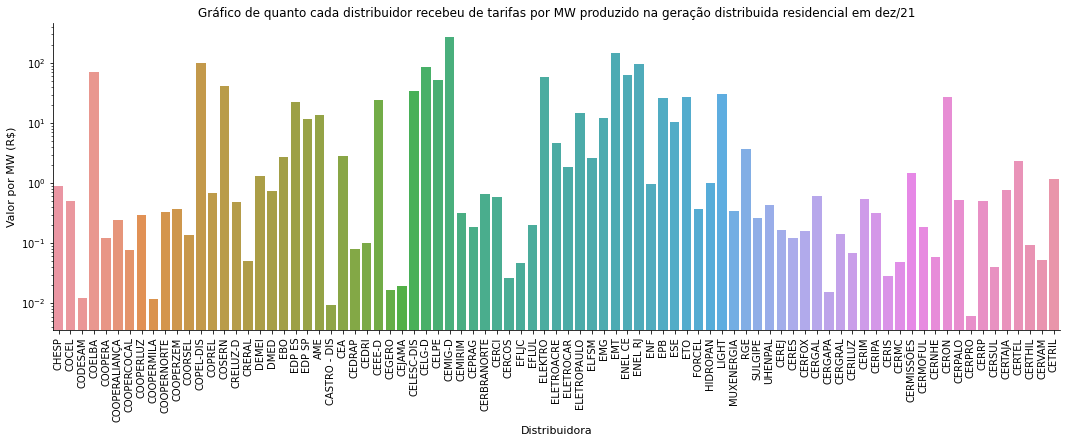

In [18]:
snsplt = sns.catplot( x="SigAgente", y="valorpormegawatt", kind="bar", data=df,aspect=30/10)
plt.xticks(rotation=90)
plt.xlabel("Distribuidora", fontsize=11)
plt.ylabel("Valor por MW (R$)", fontsize=11)
plt.yscale("log")
plt.title("Gráfico de quanto cada distribuidor recebeu de tarifas por MW produzido na geração distribuida residencial em dez/21")

In [19]:
empreendimentos_agrupadoBR = empreendimentos_gd.groupBy('26').count()
empreendimentos_agrupadoBR.show()
empreendimentos_agrupadoBR = empreendimentos_agrupadoBR.toPandas()
#contagem de total de usinas mais utilizadas por fonte energética no país

+---+------+
| 26| count|
+---+------+
|CGH|    73|
|UTE|   365|
|UFV|702928|
|EOL|    81|
+---+------+



Text(0.5, 1.0, 'Total de usinas no país por fonte energética')

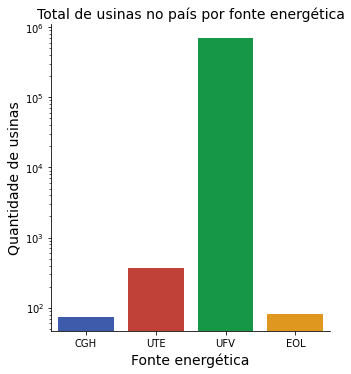

In [20]:
snsplt = sns.catplot( x="26", y="count", kind="bar", data=empreendimentos_agrupadoBR, legend=True,palette=["#2a52be", "#d62d20", "#00ad43","#ff9f00"] )
#plt.ylim(0,150)
plt.yscale("log")
plt.xlabel("Fonte energética", fontsize=14)
plt.ylabel("Quantidade de usinas", fontsize=14)
plt.title("Total de usinas no país por fonte energética", fontsize=14)
#snsplt.fig.set_size_inches(11,4)


In [21]:
empreendimentos_agrupadoRG = empreendimentos_gd.groupBy('14','26').count()
empreendimentos_agrupadoRG = empreendimentos_agrupadoRG.withColumnRenamed("14","Região").withColumnRenamed("26","Fonte Enérgetica")
empreendimentos_agrupadoRG.show()
empreendimentos_agrupadoRG = empreendimentos_agrupadoRG.toPandas()
#contagem de total de usinas mais utilizadas por fonte energética por estado

+------------+----------------+------+
|      Região|Fonte Enérgetica| count|
+------------+----------------+------+
|       Norte|             UFV| 36110|
|Centro Oeste|             CGH|     4|
|    Nordeste|             UTE|    13|
|    Nordeste|             EOL|    39|
|    Nordeste|             UFV|127945|
|         Sul|             UFV|157078|
|Centro Oeste|             UTE|    67|
|         Sul|             EOL|    27|
|         Sul|             CGH|    14|
|     Sudeste|             UFV|284075|
|         Sul|             UTE|    80|
|Centro Oeste|             UFV| 97720|
|       Norte|             EOL|     4|
|     Sudeste|             CGH|    50|
|     Sudeste|             UTE|   202|
|    Nordeste|             CGH|     1|
|     Sudeste|             EOL|    11|
|       Norte|             CGH|     4|
|       Norte|             UTE|     3|
+------------+----------------+------+



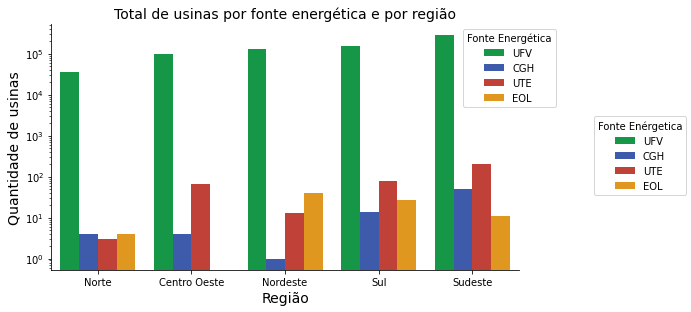

In [22]:
snsplt = sns.catplot( x="Região", y="count", kind="bar", data=empreendimentos_agrupadoRG, legend=True, hue="Fonte Enérgetica",hue_order=['UFV','CGH','UTE','EOL'],palette=["#00ad43", "#2a52be", "#d62d20","#ff9f00"])
#plt.ylim(0,150)
plt.yscale("log")
plt.xlabel("Região", fontsize=14)
plt.ylabel("Quantidade de usinas", fontsize=14)
plt.title("Total de usinas por fonte energética e por região", fontsize=14)
snsplt.fig.set_size_inches(11,4)
leg = snsplt._legend
leg.set_frame_on(True)
order = [0,1,2,3]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor = (0.87,1), title="Fonte Energética")

In [23]:
empreendimentos_agrupadoUF = empreendimentos_gd.groupBy('12','26').count()
empreendimentos_agrupadoUF = empreendimentos_agrupadoUF.withColumnRenamed("12","Estado").withColumnRenamed("26","Fonte Enérgetica")
empreendimentos_agrupadoUF.show(140)
empreendimentos_agrupadoUF = empreendimentos_agrupadoUF.toPandas()
#contagem de total de usinas mais utilizadas por fonte energética por região

+------+----------------+------+
|Estado|Fonte Enérgetica| count|
+------+----------------+------+
|    AL|             UFV|  4461|
|    CE|             UFV| 21796|
|    RN|             EOL|     7|
|    MT|             UTE|    35|
|    PA|             UFV| 16089|
|    MT|             UFV| 41627|
|    GO|             UFV| 30114|
|    BA|             UTE|     4|
|    MG|             CGH|    41|
|    ES|             CGH|     1|
|    ES|             UFV| 11202|
|    DF|             UTE|     2|
|    MS|             UFV| 21372|
|    AM|             UFV|  2829|
|    RS|             UTE|    18|
|    ES|             UTE|     7|
|    PB|             UFV| 11069|
|    RJ|             UFV| 37047|
|    PR|             UTE|    19|
|    RS|             EOL|     8|
|    GO|             CGH|     1|
|    RJ|             EOL|     1|
|    PR|             EOL|     5|
|    GO|             UTE|    18|
|    SP|             CGH|     4|
|    SC|             UFV| 22961|
|    AP|             UFV|   760|
|    AC|  

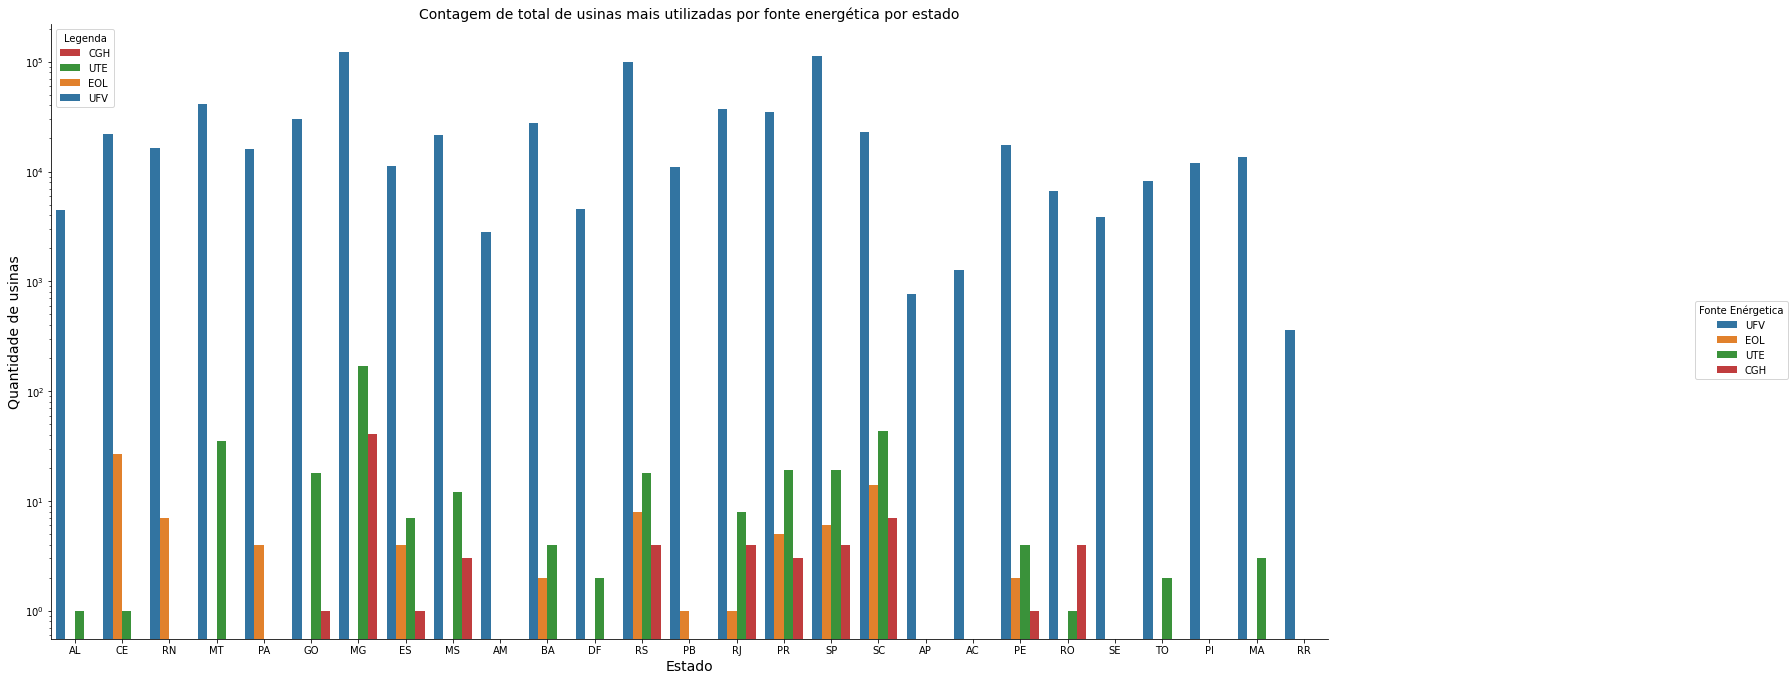

In [24]:
snsplt = sns.catplot( x="Estado", y="count", kind="bar", data=empreendimentos_agrupadoUF, legend=True, hue="Fonte Enérgetica")
# plt.ylim(0,50)
plt.yscale("log")
plt.xlabel("Estado", fontsize=14)
plt.ylabel("Quantidade de usinas", fontsize=14)
plt.title("Contagem de total de usinas mais utilizadas por fonte energética por estado", fontsize=14)
snsplt.fig.set_size_inches(30,10)
leg = snsplt._legend
leg.set_frame_on(True)
order = [3,2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper left", title="Legenda")

In [25]:
empreendimentos_agrupadoPotenciaBR = empreendimentos_gd.groupBy('26').sum()
empreendimentos_agrupadoPotenciaBR = empreendimentos_agrupadoPotenciaBR.withColumnRenamed("sum(29)","Potência (KW)")
empreendimentos_agrupadoPotenciaBR.show()
empreendimentos_agrupadoPotenciaBR = empreendimentos_agrupadoPotenciaBR.toPandas()
#potencia de energia gerada por cada fonte energética no país

+---+------------+------+-------+-------------+-------+------------------+------------------+------------------+
| 26|      sum(0)|sum(7)| sum(9)|      sum(15)|sum(25)|     Potência (KW)|           sum(30)|           sum(31)|
+---+------------+------+-------+-------------+-------+------------------+------------------+------------------+
|CGH|    28981919|   190|    549|    245093437|  16939|          66851.07|          -1314.15|          -2933.08|
|UTE|   145859019|  1083|   3013|   1362664926|   6559|         112741.13|-804.4000000000001|          -2126.71|
|UFV|247210561954|955416|6565460|2484696411040| 880609| 7818447.810001476|-759437.8699999838|-2232286.330000018|
|EOL|    33789736|   164|    753|    249912062|    147|15007.099999999999|           -133.22|           -277.03|
+---+------------+------+-------+-------------+-------+------------------+------------------+------------------+



In [26]:
empreendimentos_agrupadoPotenciaRG = empreendimentos_gd.groupBy('14','26').sum()
empreendimentos_agrupadoPotenciaRG = empreendimentos_agrupadoPotenciaRG.withColumnRenamed("14","Região").withColumnRenamed("sum(29)","Potência (KW)")
empreendimentos_agrupadoPotenciaRG.show()
empreendimentos_agrupadoPotenciaRG = empreendimentos_agrupadoPotenciaRG.toPandas()
#potencia de energia gerada por cada fonte energética por região

+------------+---+------------+------+-------+------------+-------+------------------+-------------------+-------------------+
|      Região| 26|      sum(0)|sum(7)| sum(9)|     sum(15)|sum(25)|     Potência (KW)|            sum(30)|            sum(31)|
+------------+---+------------+------+-------+------------+-------+------------------+-------------------+-------------------+
|       Norte|UFV| 11726267545| 44463| 335275| 52421621098|  42620| 432364.8600000026|-12039.979999999987|-146442.08000000007|
|    Nordeste|UTE|     5179107|    31|     95|    33445549|   1304|            9877.5|             -53.56|            -237.03|
|    Nordeste|EOL|    17149237|    68|    358|    92632606|    103|14721.060000000001|              -3.96|             -38.33|
|    Nordeste|UFV| 54163926439|166274|1196332|320952452595| 170999| 1518051.119999962| -74558.01999999986|         -397598.02|
|Centro Oeste|CGH|     2290319|    12|     27|    20215719|     63|            2460.0| -53.97999999999999|     